Here are some suggestions to improve the introduction:

**Introduction** 

The FakenewsNet repository contains comprehensive datasets of real and fake news articles published on Facebook in the week before the 2016 US election. It includes fact-checked articles from Buzzfeed News across 9 different news agencies. 

This project focuses on analysis of the Buzzfeed News dataset, which has 91 observations for both fake and real news articles across 12 feature variables. The key variables are:

- `id`: Article ID, with "fake" or "real" labels
- `title`: News headline 
- `text`: Body text of the article
- `source`: Publishing source/agency
- `images/movies`: Visual content 

Our analysis aims to uncover insights on fake news sources and language. Specifically, we compare fake and real news articles to identify:

- Sources that published more fake content 
- Words disproportionately associated with fake or real news

We use statistical tests on the source and text variables to discover these insights. 

The project has two main components:

1. Exploratory Data Analysis
2. Fake news classification models



In [1]:
# Import libraries
library(tm) # for NLP
library(plyr) #  for pre-processing 
library(tidyverse) # for pre-processing and visualisation
library(reshape2) # for melt function
library(e1071) # for Naive Bayes classifier
library(glmnet) # for Logistic Regression classifier
library(randomForest) # for Random Forest classifier

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:httr’:

    content


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ dplyr::arrange()    masks plyr::arrange()
✖ purrr::compact()    masks plyr::compact()
✖ NLP::content()      masks httr::content()
✖ dplyr::count()      masks plyr::count()
✖ dplyr::desc()       masks plyr::desc()
✖ dplyr::failwith()   masks plyr::failwith()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::id()         masks plyr::id()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::mutate()     masks plyr::mutate()
✖ dplyr::rename()     masks plyr::rename()
✖ dplyr::summar

In [2]:
buzzfeed_real <- read_csv('/kaggle/input/fakenewsnet/BuzzFeed_real_news_content.csv', show_col_types = FALSE)
head(buzzfeed_real)

id             
1 Real_1-Webpage 
2 Real_10-Webpage
3 Real_11-Webpage
4 Real_12-Webpage
5 Real_13-Webpage
6 Real_14-Webpage
  title                                                                                                       
1 Another Terrorist Attack in NYC…Why Are we STILL Being Politically Correct – Eagle Rising                   
2 Donald Trump: Drugs a 'Very, Very Big Factor' in Charlotte Protests                                         
3 Obama To UN: ‘Giving Up Liberty, Enhances Security In America…’ [VIDEO]                                     
4 Trump vs. Clinton: A Fundamental Clash over How the Economy Works                                           
5 President Obama Vetoes 9/11 Victims Bill, Setting Up Showdown With Congress                                 
6 CHAOS! NC Protest MOB Ambushes Female Truck Driver, Loots Truck, Sets Cargo On Fire – No One Helps!? [VIDEO]
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [3]:
names(buzzfeed_real)

[1] "id"             "title"          "text"           "url"           
 [5] "top_img"        "authors"        "source"         "publish_date"  
 [9] "movies"         "images"         "canonical_link" "meta_data"

In [4]:
buzzfeed_fake <- read_csv('/kaggle/input/fakenewsnet/BuzzFeed_fake_news_content.csv', show_col_types = FALSE)
head(buzzfeed_fake)

id             
1 Fake_1-Webpage 
2 Fake_10-Webpage
3 Fake_11-Webpage
4 Fake_12-Webpage
5 Fake_13-Webpage
6 Fake_14-Webpage
  title                                                                                                 
1 Proof The Mainstream Media Is Manipulating The Election By Taking Bill Clinton Out Of Context         
2 Charity: Clinton Foundation Distributed “Watered-Down” AIDS Drugs to Sub-Saharan Africa – Eagle Rising
3 A Hillary Clinton Administration May be Entirely Run by a FIGUREHEAD – Eagle Rising                   
4 Trump’s Latest Campaign Promise May Be His Most Horrible One Yet                                      
5 Website is Down For Maintenance                                                                       
6 Obama Pushes One World Government                                                                     
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [5]:
names(buzzfeed_fake)

[1] "id"             "title"          "text"           "url"           
 [5] "top_img"        "authors"        "source"         "publish_date"  
 [9] "movies"         "images"         "canonical_link" "meta_data"

In [6]:
# assuming that "addictinginfo.org" is one news source with different url or source
# Hence,combining all sources of "addictinginfo.org" into one for our analysis.
buzzfeed_fake$source <- gsub("www.addic|author.addic", "addic",buzzfeed_fake$source)
buzzfeed_real$source <- gsub("www.addic|author.addic", "addic",buzzfeed_real$source)

In [7]:
#Merging datasets
buzzfeed_data = rbind(buzzfeed_real, buzzfeed_fake)


In [8]:
# adding new column type for categorizing document as real or fake
buzzfeed_data$type <- sapply(strsplit(buzzfeed_data$id, "_"), head, 1)

In [9]:
buzzfeed_data$type

[1] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [11] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [21] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [31] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [41] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [51] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [61] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [71] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [81] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [91] "Real" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[101] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[111] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[121] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[131] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[141] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[151] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[161] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[171] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[181] "Fake" "Fake"

In [10]:
dim(buzzfeed_data)

[1] 182  13

In [11]:
summary(buzzfeed_data)

      id               title               text               url           
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   top_img            authors             source          publish_date      
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
    movies             images          canonical_link      meta_data        
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
     type          
 Length:182        
 Class :character  
 Mode  :characte

dataset comprises of 182 rows and 13 columns and all variables are char type and there are no NaN values

In [12]:
# select necessary columns from the dataframe for analysis
buzzfeed_data <- buzzfeed_data %>% select(c("id","title","text","source","type","images","movies"))

In [13]:
# movies and images as logical, if available then 1 and if not then 0
buzzfeed_data$movies<- ifelse(is.na(buzzfeed_data$movies) , 0, 1)
buzzfeed_data$images<- ifelse(is.na(buzzfeed_data$images) , 0, 1)

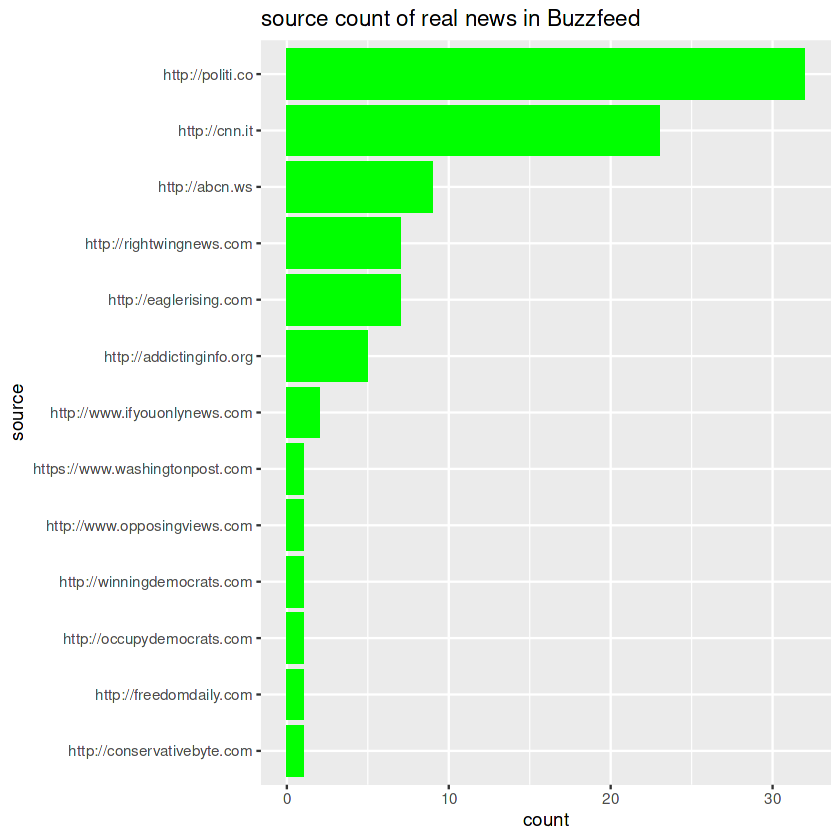

In [14]:
# Lets findout which sources published real news
buzzfeed_real$source <- with(buzzfeed_real, reorder(source, source, function(x) length(x)))
ggplot(data = buzzfeed_real) +
  ggtitle("source count of real news in Buzzfeed") +
  geom_bar(aes(x= source),fill = "green") + coord_flip()

politi.co reports maximum real news folowed by cnn.it

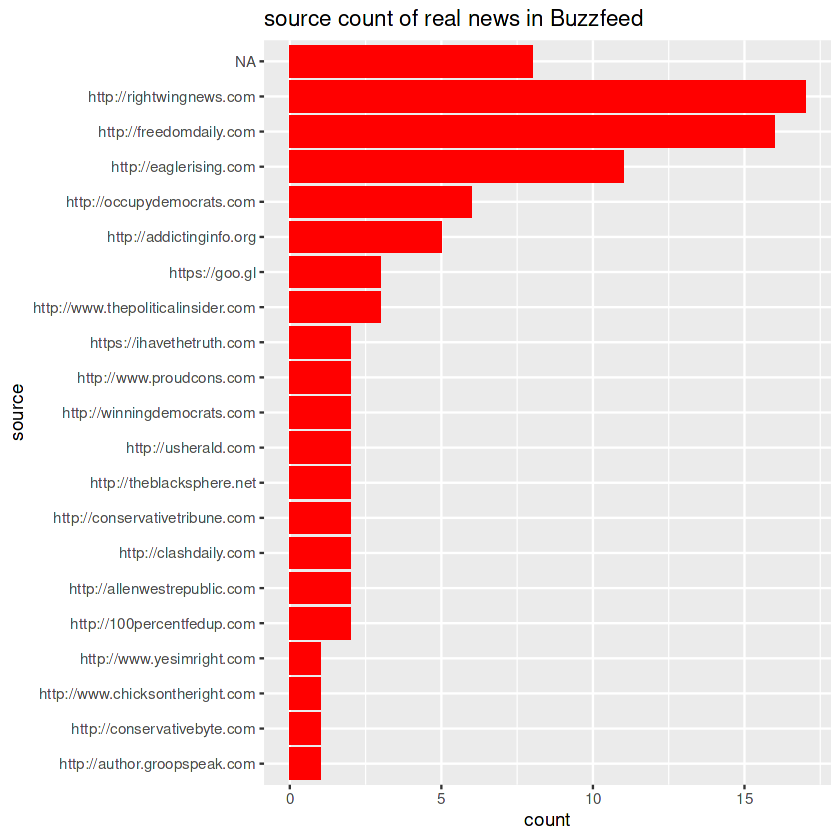

In [15]:
# Lets findout which sources produced fake news
buzzfeed_fake$source <- with(buzzfeed_fake, reorder(source, source, function(x) length(x)))
ggplot(data = buzzfeed_fake) +
  ggtitle("source count of real news in Buzzfeed") +
  geom_bar(aes(x= source),fill = "red") + coord_flip()

from the plot we can say that rightwingnews produced more fake news followed by freedomdaily and eagleraising. Also, there are some news which are reported but their source is unknown

From the 2 plots we can see some sources produced both real and fake news. Lets analyze whether a particular source produces more fake news than real news.

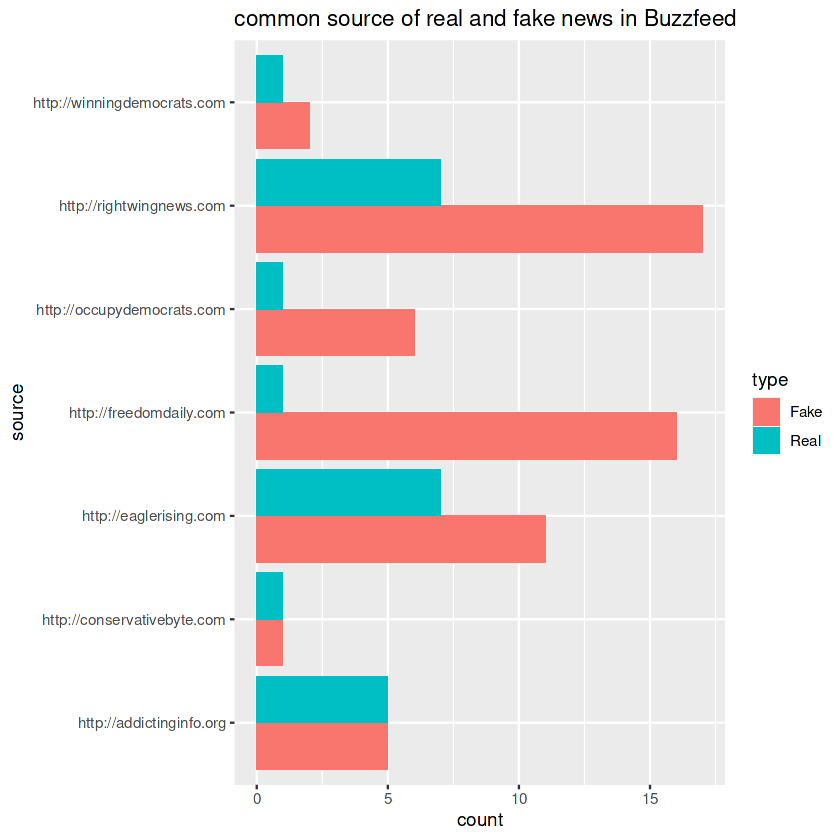

In [16]:
# Check for common sources of fake news and real news
common_source <- intersect(buzzfeed_real$source,buzzfeed_fake$source)
source_type_counts = table(buzzfeed_data$source, buzzfeed_data$type)

# Bar chart of source 
ggplot(buzzfeed_data[which(buzzfeed_data$source %in% common_source),]) + 
  geom_bar(aes(x = source,fill = type),position = "dodge") + coord_flip() +
  ggtitle("common source of real and fake news in Buzzfeed") 

There are 8 common news sources that published both real and fake articles in the dataset. The source 'rightwingnews' published the most fake news - about two-thirds of their total articles were labeled as fake. 'freedomdaily' had the second highest number of fake news articles, and very rarely published real news. Notably, 'addictinginfo.org' is the only source that published more real than fake news, though their total number of articles is small.

Overall, we see that most of the common sources published substantially more fake news than real news in the dataset. Sources like 'rightwingnews' and 'freedomdaily' accounted for a large portion of the fake content. This highlights that certain news agencies were much more likely to spread fake stories than others in the lead up to the 2016 election.

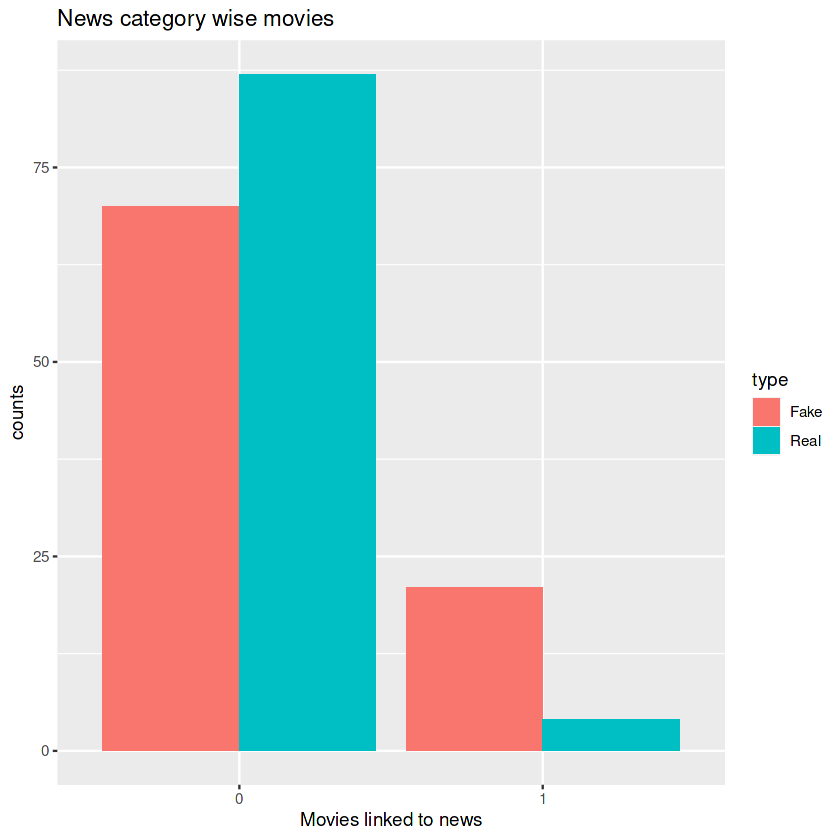

In [17]:
# Lets check if the sources include movies in the news to get more attantion
ggplot(buzzfeed_data) +
  geom_bar(aes(x= factor(movies), fill = type),position = "dodge")  +
  xlab("Movies linked to news") + ylab("counts") + 
  theme() + ggtitle("News category wise movies") 

- Most news don't contain movies overall
- But fake news more often includes movies than real news
- This variable does not seem very useful for analysis
- Similar distributions for real and fake news

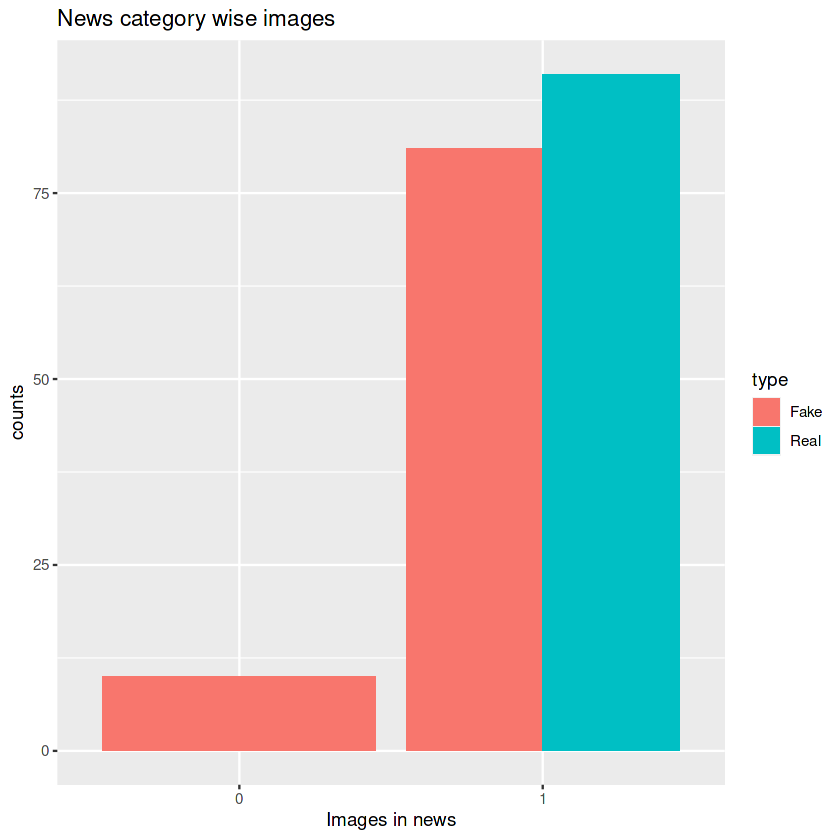

In [18]:
ggplot(buzzfeed_data) +
  geom_bar(aes(x= as.factor(images), fill = type),position = "dodge")+
  xlab("Images in news") + ylab("counts") + 
  theme() + ggtitle("News category wise images") 

The plot shows all real news articles contain images, while some fake news does not. This suggests images serve as visual evidence in real reporting. Overall though, the image variable does not provide much insight, as both real and fake news distribute images similarly. The image and movie variables give little detail to strengthen our analysis, so we will focus our text mining on other features.

In [19]:
suppressWarnings(# lets analyze title and body of the news articles
# for preprocessing texts following operations are employed by preprocess_corpus()function
# Convert text to lower case
# Remove Numbers from the text corpus.
# Remove punctuation from the text corpus.
# Remove some special characters such as ‘<’, ‘…’ from the text
# Remove english stopwords.
# Remove common news source names from text corpus.
# Stemming words to root words
# Remove extra whitespaces from the text corpus.
clean_text <- function(x){ 
  gsub("…|⋆|–|‹|”|“|‘|’", " ", x) 
})

In [20]:
suppressWarnings(
    preprocess_corpus <- function(corpus){
  # Convert the text to lower case
  corpus <- tm_map(corpus, content_transformer(tolower))
  # Remove numbers
  corpus <- tm_map(corpus, removeNumbers)
  # Remove punctuations
  corpus <- tm_map(corpus, removePunctuation)
  # Remove special characters from text
  corpus <- tm_map(corpus, clean_text)
  # Remove english common stopwords
  corpus <- tm_map(corpus, removeWords, stopwords("english"))
  # Remove name of newspapers from the corpus
  corpus <- tm_map(corpus, removeWords, c("eagle rising","freedom daily"))
  # 'stem' words to root words
  corpus <- tm_map(corpus,stemDocument)
  # Eliminate extra white spaces
  corpus <- tm_map(corpus, stripWhitespace)
  return (corpus)
})


In [21]:
# lets find words which represent Fake and Real news using chi sqare statistics
suppressWarnings(find_category_representative_words_using_chi_sq <- function(dtf_matrix, categories, top_n=20){
  dtm_df <- data.frame(dtf_matrix)
  # find top features using chi-sq test 
  chi2vals <- apply(dtf_matrix, 2, function(x){
    chisq.test(as.numeric(x), categories)$statistic
  })
  features_subset <- names(sort(chi2vals, decreasing = TRUE))[1:top_n]
  
  # Compute term frequency for top terms in both categories 
  dtm_df$NewsType <- categories
  cat_freq_df <- dtm_df %>% group_by(NewsType) %>% summarise_each(funs(sum))
  top_words_freq <- cat_freq_df[, c(features_subset, "NewsType")]
  return (top_words_freq)
})

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, clean_text):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, c("eagle rising", "freedom daily")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”
Using NewsType as id variables



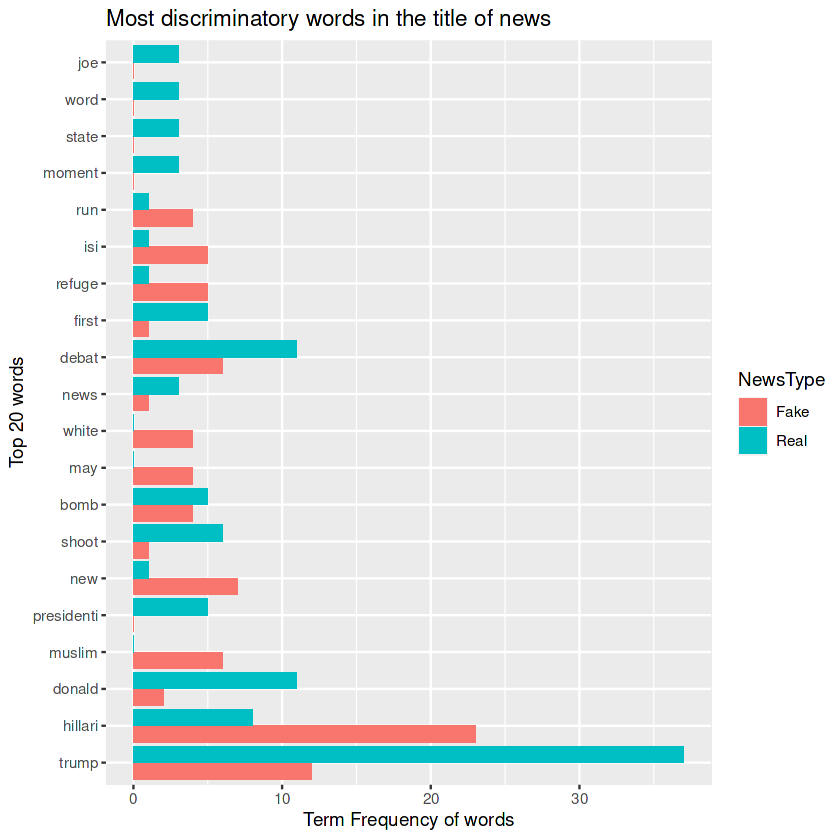

In [22]:

# Lets do analysis on Buzzfeed news title(unigrams)
# Buzzfeed title corpus
title_corpus <- Corpus(VectorSource(buzzfeed_data$title))
# convert title corpus to document term matrix
title_dtm <- DocumentTermMatrix(preprocess_corpus(title_corpus))

title_dtm_matrix <- as.matrix(title_dtm)
# finding top 20 words in the news title for both categories
suppressWarnings(
title_top_words_freq <- find_category_representative_words_using_chi_sq(title_dtm_matrix,buzzfeed_data$type,20)
)
    # ploting category wise term frequency of the top 20 discriminatory words in the news title 
ggplot(melt(title_top_words_freq),aes(x =variable, y=value,fill = NewsType)) + geom_col(position = "dodge") + coord_flip() + xlab("Top 20 words") + ylab("Term Frequency of words") + 
  theme() + ggtitle("Most discriminatory words in the title of news") 


Analysis reveals fake news titles frequently contain provocative, emotive words like 'muslim' and 'refuge' while real news titles use more factual words like 'president' and 'state'. The exaggerated language in fake news aligns with clickbait tactics to drive clicks through outrage, not accuracy. However, while suggestive of intent, title words alone don't prove clickbait or misinformation - further examination of article content is required. But the stark differences in title wording point to fake news being optimized to provoke strong reactions rather than inform, unlike the real news."

In [23]:
#  Lets do analysis on Buzzfeed news body(unigrams)
# Buzzfeed text body corpus
body_corpus <- Corpus(VectorSource(buzzfeed_data$text))
# convert body corpus to document term matrix
body_dtm <- DocumentTermMatrix(preprocess_corpus(body_corpus))
body_dtm_matrix <- as.matrix(body_dtm)
# finding top 30 words in the news body for both categories
suppressWarnings(
body_top_words_freq <- find_category_representative_words_using_chi_sq(body_dtm_matrix,buzzfeed_data$type,30)
)


Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, clean_text):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, c("eagle rising", "freedom daily")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stemDocument):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”


Using NewsType as id variables



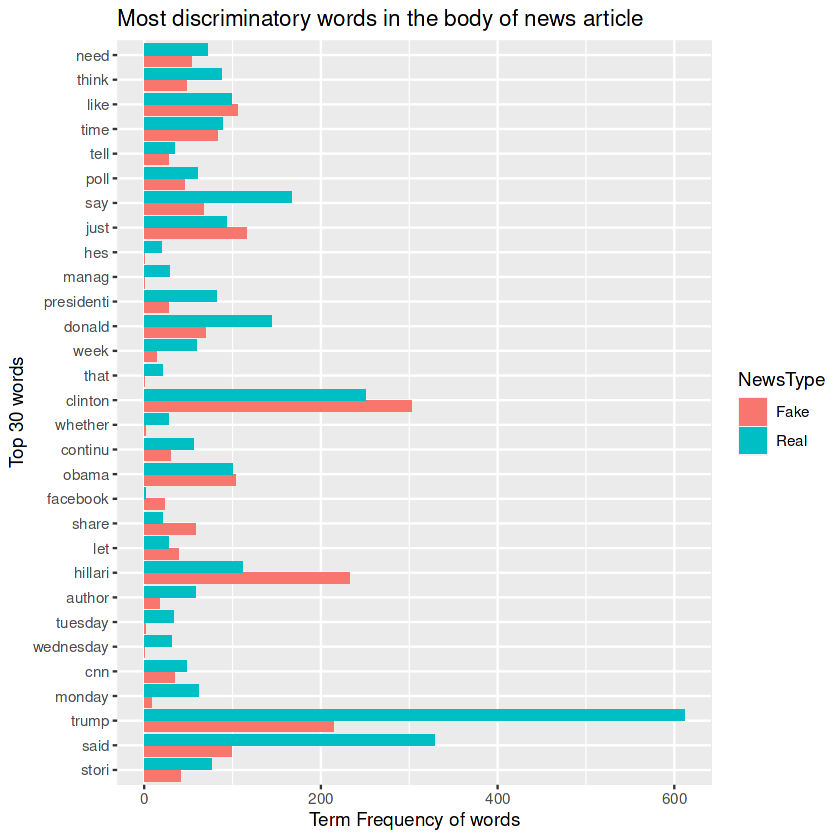

In [24]:
# ploting category wise term frequency of the top 30 discriminatory words in the news article body
ggplot(melt(body_top_words_freq),aes(x =variable, y=value,fill = NewsType)) + 
  geom_col(position = "dodge") + coord_flip() + xlab("Top 30 words") + ylab("Term Frequency of words") + 
  theme() + ggtitle("Most discriminatory words in the body of news article")

The body word usage reveals 'hillary', 'clinton', 'obama' associate more with fake news while 'donald', 'trump', 'said', 'think' appear more in real news. Fake news also exhibits more words tied to social media like 'twitter' and 'facebook', likely aiming to catch reader attention. The heightened use of prominent figures' names and social platforms in fake news suggests an intent to provoke reactions over informing, unlike the real news content.

In [25]:
# Lets analyze whether title length is also a factor in identifying real and fake news

# length of title for histogram
title_length <- rowSums(title_dtm_matrix)
# data frame of title length with categories
tl_df <- data.frame(title_length, buzzfeed_data$type)

# perform t-test
t.test(tl_df[tl_df$buzzfeed_data == "Real",]$title_length, tl_df[tl_df$buzzfeed_data == "Fake",]$title_length)


	Welch Two Sample t-test

data:  tl_df[tl_df$buzzfeed_data == "Real", ]$title_length and tl_df[tl_df$buzzfeed_data == "Fake", ]$title_length
t = -2.3407, df = 177.45, p-value = 0.02036
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.4582691 -0.1241485
sample estimates:
mean of x mean of y 
 7.021978  7.813187 


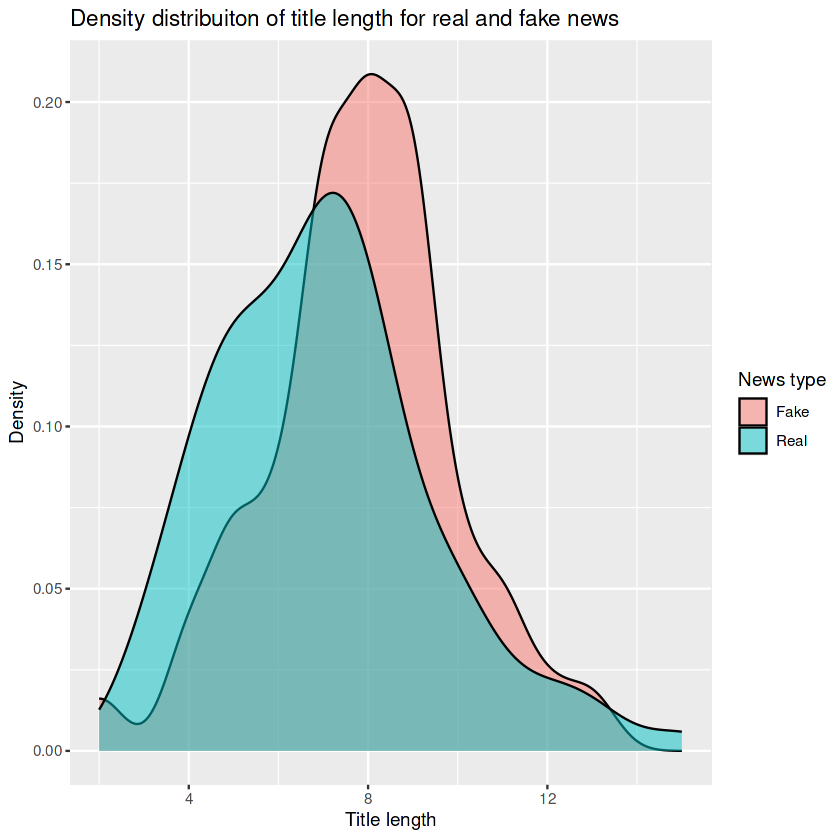

In [26]:
# plotting histogram of title length
ggplot(tl_df ,aes(x = title_length, fill = buzzfeed_data.type)) +
  geom_density(alpha=0.5) +
  guides(fill=guide_legend(title="News type")) + 
  xlab("Title length") + ylab("Density") + theme() + 
  ggtitle("Density distribuiton of title length for real and fake news")

Statistical tests reveal fake news titles are significantly longer than real news titles on average. The fake news title length distribution is centered on the mean while the real news distribution is right-skewed. This indicates fake news titles use more words, aligning with clickbait tendencies to sensationalize content to attract attention. The shorter real news titles reflect a more concise, fact-based approach

In [27]:
# Lets analyze bigramsn in the body of news articles
# function to tokenize bigrams
BigramTokenizer <-
  function(x)
    unlist(lapply(ngrams(words(x), 2), paste, collapse = " "), use.names = FALSE)
# corpus for bigrams
corpus <- VCorpus(VectorSource(buzzfeed_data$text))
# corpus to document term matrix of bigrams
bigram_matrix <- DocumentTermMatrix(corpus, control = list(tokenize = BigramTokenizer))
# sort frequency of bigrams in decreasing order to give high frequency phrases
bigram_freq <- sort(colSums(as.matrix(bigram_matrix)), decreasing=TRUE)

In [28]:
find_top_bigram <- function(bigrams, top_n){
  top_bigram_list <- c()
  for(bigram in bigrams){
    unigrams <- strsplit(bigram," ")
    if(!(unigrams[[1]][1] %in% stopwords("en") | unigrams[[1]][2]  %in% stopwords("en"))){
      top_bigram_list <- c(top_bigram_list, bigram)
    }
    if (length(top_bigram_list) ==top_n){
      break
    }
  }
  return (top_bigram_list)
}
features_subset <- find_top_bigram(names(bigram_freq), 20)
dtm_bigram_df <- data.frame(as.matrix(bigram_matrix[, intersect(colnames(bigram_matrix),features_subset)]))
dtm_bigram_df$NewsType <- buzzfeed_data$type
cat_freq_bf_df <- dtm_bigram_df %>% group_by(NewsType) %>% summarise_each(funs(sum))

Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


Using NewsType as id variables



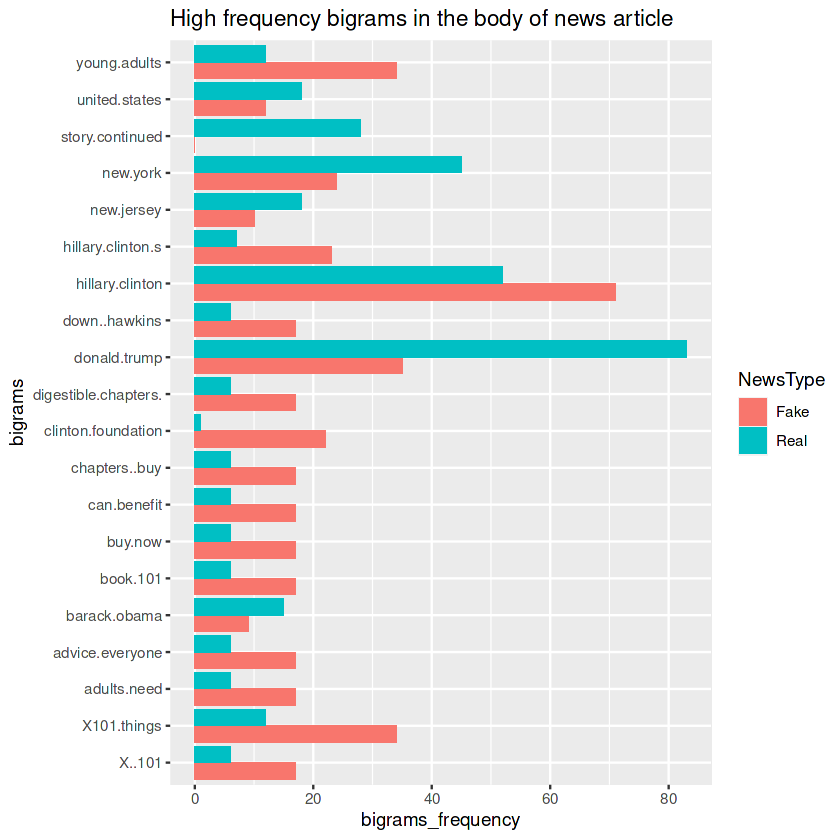

In [29]:
# plot high frequency bigrams in the body of news articles.
ggplot(melt(cat_freq_bf_df),aes(x =variable, y=value,fill = NewsType)) + 
  geom_col(position = "dodge") + coord_flip() + xlab("bigrams") + ylab("bigrams_frequency") + 
  theme() + ggtitle("High frequency bigrams in the body of news article")

 key observations regarding the frequent phrases used in real vs fake news:

- 'donald.trump' is most common in real news, while 'hillary.clinton' dominates fake news. 

- Phrases like 'young.adults', 'clinton.foundation' appear more frequently in fake news.

- 'barack.obama', 'new.york', 'united states' are more prevalent in real news.

In summary, real news exhibits more neutral descriptors of people, places and institutions. Fake news relies more on frequent usage of controversial figures' names, invoking reactions. The phrase differences quantify the observation that real news has a more informational style while fake news contains more provocative, personality-focused language.

In [30]:
set.seed(123)
n_obs <- nrow(buzzfeed_data)
prop_split <- .75
training_index <- sample(1:n_obs, round(n_obs * prop_split))

In [31]:
inspect(title_dtm[100:105,100:105]) 

<<DocumentTermMatrix (documents: 6, terms: 6)>>
Non-/sparse entries: 0/36
Sparsity           : 100%
Maximal term length: 8
Weighting          : term frequency (tf)
Sample             :
     Terms
Docs  holt hostil moder postdeb question team
  100    0      0     0       0        0    0
  101    0      0     0       0        0    0
  102    0      0     0       0        0    0
  103    0      0     0       0        0    0
  104    0      0     0       0        0    0
  105    0      0     0       0        0    0


The matrix is sparse. which means most of the words in the title and body of the articles which are less useful as predictors.

In [32]:
# Remove sparse terms 
sparse_title_dtm <- removeSparseTerms(title_dtm, .997) # 750 terms
sparse_title_dtm 

<<DocumentTermMatrix (documents: 182, terms: 750)>>
Non-/sparse entries: 1335/135165
Sparsity           : 99%
Maximal term length: 15
Weighting          : term frequency (tf)

In [33]:
title_dtm <- as.matrix(sparse_title_dtm)
# set train and test set for title dtm
y_true <- as.matrix(buzzfeed_data$type)
x_train <- title_dtm[training_index, ]
x_test <- title_dtm[-training_index, ]

In [34]:
#Base line model -> Naive Bayes Classifier
nb_title <- naiveBayes(x=x_train , y=as.factor(y_true[training_index]))
predicted_rf_title <- predict(nb_title, x_test)
accuracy_nb_title <- sum(y_true[-training_index] == predicted_rf_title)/ length(predicted_rf_title)
accuracy_nb_title

[1] 0.4565217

In [35]:
# Logistic Regression Classifier
glm_fit_title <- glmnet(x_train , y_true[training_index], family = "binomial")
predicted_glm_title <- predict(glm_fit_title, x_test, type = "class")
accuracy_glm_title <- sum(y_true[-training_index] == predicted_glm_title)/ length(predicted_glm_title)
accuracy_glm_title

[1] 0.6326087

Logistic Regression performs better than Naive Bayes

In [36]:
#Random Forest Classifier
set.seed(123)
rf_title <- randomForest(x=x_train, y=as.factor(y_true[training_index]),ntree = 50)
rf_title



Call:
 randomForest(x = x_train, y = as.factor(y_true[training_index]),      ntree = 50) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 27

        OOB estimate of  error rate: 44.12%
Confusion matrix:
     Fake Real class.error
Fake   34   32   0.4848485
Real   28   42   0.4000000

In [37]:
predicted_rf_title <- predict(rf_title, newdata=x_test)
accuracy_rf_title <- sum(y_true[-training_index] == predicted_rf_title)/ length(predicted_rf_title)
accuracy_rf_title 

[1] 0.7173913

accuracy of random forest classifier is 71% which is better than Logistic Regression

In [38]:
# Fake News detection by body of the article
# Let's remove some terms that don't appear very often and making body_dtm denser
sparse_body_dtm <- removeSparseTerms(body_dtm, 0.97) # 1337 terms
sparse_body_dtm

<<DocumentTermMatrix (documents: 182, terms: 1337)>>
Non-/sparse entries: 23641/219693
Sparsity           : 90%
Maximal term length: 15
Weighting          : term frequency (tf)

In [39]:
body_dtm <- as.matrix(sparse_body_dtm)
# set train and test set for body dtm
y_true <- as.matrix(buzzfeed_data$type)
x_train_body <- body_dtm[training_index,]
x_test_body <- body_dtm[-training_index, ]

In [40]:
#Base line model -> Naive Bayes Classifier
nb_body <- naiveBayes(x=x_train_body , y=as.factor(y_true[training_index]))
predicted_naive_body <- predict(nb_body, x_test_body)
accuracy_naive_body <- sum(y_true[-training_index] == predicted_naive_body)/ length(predicted_naive_body)
accuracy_naive_body

[1] 0.6086957

In [41]:
# Logistic Regression Classifier
glm_fit_body <- glmnet(x_train_body , y_true[training_index], family = "binomial")
predicted_glm_body <- predict(glm_fit_body, x_test_body, type = "class")
accuracy_glm_body <- sum(y_true[-training_index] == predicted_glm_body)/ length(predicted_glm_body)
accuracy_glm_body 

[1] 0.6928261

Logistic Regression performed better than Naive Bayes

In [42]:
# Random Forest Classifier
set.seed(123)
rf_body <- randomForest(x=x_train_body, y=as.factor(y_true[training_index]))
rf_body



Call:
 randomForest(x = x_train_body, y = as.factor(y_true[training_index])) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 36

        OOB estimate of  error rate: 22.79%
Confusion matrix:
     Fake Real class.error
Fake   53   13   0.1969697
Real   18   52   0.2571429

In [43]:
predicted_rf_body <- predict(rf_body, newdata=x_test_body)
accuracy_rf_body <- sum(y_true[-training_index] == predicted_rf_body)/ length(predicted_rf_body)
accuracy_rf_body

[1] 0.8043478

Random Forest performed better than the other models with accuracy of 74%

In [44]:
# Lets build a model to identify fake news based on either title or body of the article
# combine title and body terms as feature matrix
title_body_dtm <- body_dtm
common_features <- intersect(colnames(body_dtm), colnames(title_dtm))
title_body_dtm[,common_features] <- body_dtm[,common_features]+ title_dtm[,common_features]
title_only_features <- setdiff(colnames(title_dtm), colnames(body_dtm))
title_body_dtm <- cbind(title_body_dtm, title_dtm[,title_only_features])

In [45]:
#Base line model -> Naive Bayes Classifier
nb_body_tb <- naiveBayes(x=title_body_dtm[training_index, ] , y=as.factor(y_true[training_index]))
predicted_nb_tb <- predict(nb_body, title_body_dtm[-training_index, ])
accuracy_nb_tb <- sum(y_true[-training_index] == predicted_nb_tb)/ length(predicted_nb_tb)
accuracy_nb_tb

[1] 0.6521739

Accuracy of the Naive Bayes Classifier have not improved even when features changed.

In [46]:
# Logistic Regression
glm_fit_title_body <- glmnet(x=title_body_dtm[training_index, ] , y=y_true[training_index], family = "binomial")
predicted_glm_tb <- predict(glm_fit_title_body, title_body_dtm[-training_index, ], type = "class")
accuracy_glm_tb <- sum(y_true[-training_index] == predicted_glm_tb)/ length(predicted_glm_tb)
accuracy_glm_tb 

[1] 0.7452174

Logistic regression performed better with combined feature matrix